1. Import the required libraries

In [ ]:
# import necessary libraries
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import OneCycleLR
import pandas as pd
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# mount Gdrive to access datasets
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


2. Load the given datasets from Kaggle. There are 3 datasets being called: train_data.csv, train_target.csv, and test_data.csv.

In [ ]:
# load training data
train_data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/train_data.csv', header=None)
train_target = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/train_target.csv', header=None)

# load testing data
test_data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/test_data.csv', header=None)


3. Upon running program, use CUDA GPU on Google Colab for faster runtimes.

In [ ]:
# use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

4. Create a Custom Datset Class for handling image data.

In [ ]:
# custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data  # image data
        self.target = target  # corresponding labels
        self.transform = transform  # applied tranformations on images

    def __len__(self):
        return len(self.data) # return size of dataset

    def __getitem__(self, idx):
        image_data = self.data.iloc[idx, :].values
        image_data = image_data.reshape(48, 48).astype(np.uint8) # reformat image data
        image = Image.fromarray(image_data) # covert array to PIL image

       # apply transformation if necessary
        if self.transform:
            image = self.transform(image)

        target = self.target.iloc[idx, 0]

        return image, target

5. Define transformations for image data

In [ ]:
# define transformations for data
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # convert image to grayscale
    transforms.ToTensor()             # convert image to Pytorch tensor
])

# tranformations to randomly flip, rotate, jitter color, normal and convert to Pytorch tensor
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.ToTensor()
])


6. Creating the datasets and data loaders.


In [ ]:
# create datasets
X_train, X_val, y_train, y_val = train_test_split(train_data, train_target, test_size=0.2, random_state=42)

train_dataset = CustomDataset(X_train, y_train, transform=transform)
val_dataset = CustomDataset(X_val, y_val, transform=transform)
test_dataset = CustomDataset(test_data, pd.DataFrame(np.zeros((len(test_data), 1))), transform=transform)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

7. Creating the CNN Model.

In [ ]:
# CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # first convolution block
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1) # convulution
        self.bn1 = nn.BatchNorm2d(64)   # batch normalization = 64
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # convulution
        self.bn2 = nn.BatchNorm2d(64)   # batch normalization = 64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # second convolution block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)   # convultion
        self.bn3 = nn.BatchNorm2d(128)    # batch normalization = 128
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)    # batch normalization = 128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        #  connected Layers
        self.fc1 = nn.Linear(128 * 12 * 12, 256)  # first fully connected layer
        self.dropout1 = nn.Dropout(0.5)   # first dropout layer to prevent overfitting
        self.fc2 = nn.Linear(256, 128)    #second fully connected layer
        self.dropout2 = nn.Dropout(0.5)   # first dropout layer to prevent overfitting
        self.fc3 = nn.Linear(128, 3)    # last fully connected layer

    def forward(self, x):
        # first Convolution Block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        # second Convolution Block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        # flatten output for the dense layers
        x = x.view(-1, 128 * 12 * 12)

        # fully Connected Layers
        x = F.relu(self.fc1(self.dropout1(x)))
        x = F.relu(self.fc2(self.dropout2(x)))
        x = self.fc3(x)

        return x

# create instance of the model
model = CNNModel()

8. Defining the number of epochs, loss function, optimizer, and learning rate scheduler.

In [ ]:
# defining epoch value, loss function and optimizer
num_epochs = 15  # number of epochs set
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5) # optimizer using AdamW
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=num_epochs) # setting learning rate scheduler

9. Create the training loop.

In [ ]:
# initilize to store metrics for graphs later on
train_losses, train_accuracies = [], []
learning_rates = []

# training loop
for epoch in range(num_epochs):
    model.train()     # switch to training mode
    running_loss, total, correct = 0.0, 0, 0

    # iterate training data
    for images, labels in train_loader:
        optimizer.zero_grad()   # reset gradient
        outputs = model(images)   # forward pass
        loss = criterion(outputs, labels) # compute loss
        loss.backward()   # backwards pass
        optimizer.step()    # update weights
    scheduler.step()  # update learning rate scheduler

    # tracking loss and accuracy values for our graphs
    running_loss += loss.item()
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # track and record learning rate
    learning_rates.append(scheduler.get_last_lr()[0])

    # validation Phase
    model.eval()    # switch to validation mode
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}, Validation Accuracy: {val_accuracy}%')

Epoch 1, Validation Accuracy: 60.865533230293664%
Epoch 2, Validation Accuracy: 65.53323029366307%
Epoch 3, Validation Accuracy: 70.54095826893354%
Epoch 4, Validation Accuracy: 71.19010819165379%
Epoch 5, Validation Accuracy: 72.55023183925812%
Epoch 6, Validation Accuracy: 74.2194744976816%
Epoch 7, Validation Accuracy: 74.71406491499228%
Epoch 8, Validation Accuracy: 74.74497681607419%
Epoch 9, Validation Accuracy: 75.17774343122102%
Epoch 10, Validation Accuracy: 75.98145285935085%
Epoch 11, Validation Accuracy: 75.14683153013911%
Epoch 12, Validation Accuracy: 76.13601236476043%
Epoch 13, Validation Accuracy: 77.43431221020093%
Epoch 14, Validation Accuracy: 77.43431221020093%
Epoch 15, Validation Accuracy: 76.66151468315302%


10. Plot training loss graph, accuracy graph, learning rate schuduler graph, and data preprocessing graph.

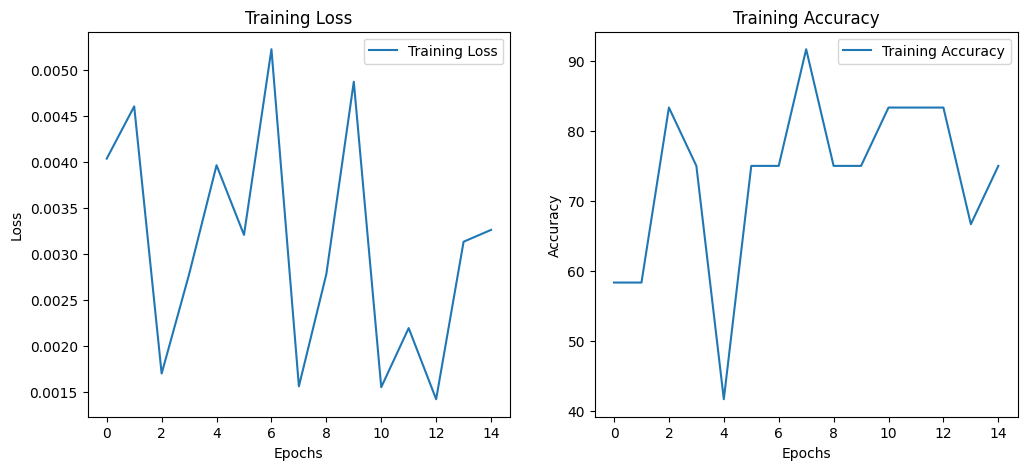

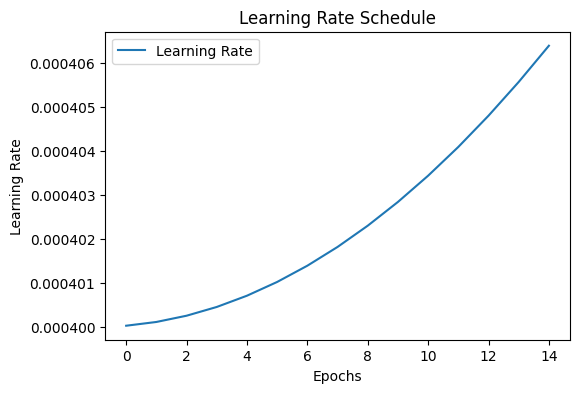

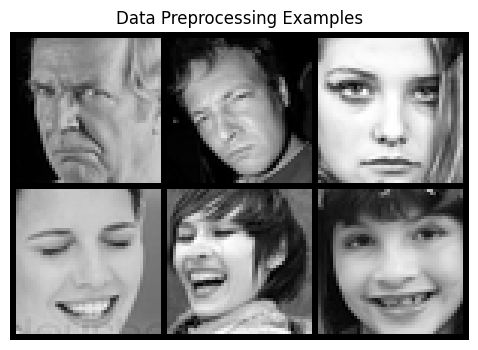

In [ ]:
# plot training loss and accuracy graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plot learning rate scheduler graph
plt.figure(figsize=(6, 4))
plt.plot(learning_rates, label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

# plot data preprocessing graph
def show_transformed_images(dataset):
    loader = DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, _ = batch

    grid_img = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(12, 4))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title('Data Preprocessing Examples')
    plt.axis('off')
    plt.show()

show_transformed_images(train_dataset)

11. Evaluate validation data.

In [ ]:
# evaluate on validation data
model.eval()
val_predictions = []
val_targets = []

# take all predictions and targets
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        val_predictions.extend(predicted.cpu().numpy())
        val_targets.extend(labels.cpu().numpy())

val_accuracy = accuracy_score(val_targets, val_predictions)
print(f'Our Validation Accuracy is: {val_accuracy}')

Our Validation Accuracy is: 0.7666151468315301


12. Evaluate validation data to the test data.

In [ ]:
# run validation predictions on test data
test_predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_predictions.extend(predicted.tolist())

13. Download the final accuracy score to Google Drive.

In [ ]:
# send output to submission.csv to Gdrive, and print final accuracy

submission_df = pd.DataFrame({'Id': range(len(test_predictions)), 'Category': test_predictions})
submission_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/submission.csv', index=False)

print(f'Our Final Validation Accuracy is: {val_accuracy}')

Our Final Validation Accuracy is: 0.7666151468315301
